#### Base imports

`%aiida` magic spawns AiiDA's environment and imports some classes like `Code` and `DataFactory`.

I also use `ipywidgets` module in notebooks to select interactively some inputs. Handy to e.g. make queries and check if you have some pseudo in any family etc.

In [66]:
%aiida

** Note! AiiDA DB environment already loaded! I do not reload it again.

In [67]:
%matplotlib inline

In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact

In [51]:
code = None
def select_code(codename):
    global code
    code = Code.get_from_string(codename)

code_choice = interact(select_code, 
                       codename=Code.list_for_plugin('siesta.siesta'))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY29kZW5hbWUnLCBvcHRpb25zPSh1J3NpZXN0YScsIHUnc2llc3RhbXBpJyksIHZhbHVlPXUnc2llc3RhJyksIE/igKY=


In [50]:
vibra_code = None
def select_vibra_code(codename):
    global vibra_code
    vibra_code = Code.get_from_string(codename)

vibra_code_choice = interact(select_vibra_code, 
                             codename=Code.list_for_plugin('siesta.vibra'))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY29kZW5hbWUnLCBvcHRpb25zPSh1J3ZpYnJhJywpLCB2YWx1ZT11J3ZpYnJhJyksIE91dHB1dCgpKSwgX2RvbV/igKY=


In [16]:
from aiida.orm.data.base import Int, Float, Str

PsfData = DataFactory('siesta.psf')
StructureData = DataFactory('structure')
ParameterData = DataFactory('parameter')
KpointsData = DataFactory('array.kpoints')
ArrayData = DataFactory('array')

#### Pseudopotentials

In other notebooks I search and select the family via widget.

But at the moment we have the `lda-ag` pseudo-family hardwired in a number of places, including the "protocols" of the workflow for vibra (which is not really good). 

Thus, selection of pseusos is done by protocol. I leave the code for selectors in the markdown cells for reference:

```
filter_elements=("Si")
```

```
pseudo_family = None
def select_pseudo_family(family):
    global pseudo_family
    pseudo_family = family
    
pseudo_family_choice = interact(select_pseudo_family,
                                family=PsfData.get_psf_groups(filter_elements=filter_elements))
```

#### Vibra's workflow inputs:

In [24]:
# Protocol selection
protocol = Str("standard")

In [72]:
# Supercell definition
# 
# Mind the name `sca` for the sc-dimensions array. That is hardwired too.
scarray=ArrayData()
scarray.set_array('sca',np.array([1, 1, 1]))

##### Structure creators

In [27]:
def create_diamond_structure(alat):
    """ Create diamond structure with `alat` lattice parameter. """
    cell = np.array([[0.5, 0.5, 0.0,],
                     [0.0, 0.5, 0.5,],
                     [0.5, 0.0, 0.5,],]) * alat
    structure = StructureData(cell=cell)

    return structure

In [33]:
alat = 5.43

si_structure = create_diamond_structure(alat)

si_structure.append_atom(position=(0.000 * alat, 0.000 * alat, 0.000 * alat), 
                         symbols=['Si'])
si_structure.append_atom(position=(0.250 * alat, 0.250 * alat, 0.250 * alat),
                         symbols=['Si'])

In [47]:
bandskpoints = KpointsData()
bandskpoints.set_cell(si_structure.cell, si_structure.pbc)
bandskpoints.set_kpoints_path([
    ('G', 'X', 20),
    ('X', 'K', 10),
    ('K', 'G', 20),
    ('G', 'L', 20),
    ('L', 'X', 20),
    ('X', 'W', 5),
    ('W', 'L', 10),
])

#### Workflow stages parameters

The atomic displacement for force constants calculations is taken from `global_parameters`. Somewhere (perhaps there) system- and mpi-options 
should be also defined.

`siesta_parameters` and `vibra_parameters` update corresponding defaults 
from protocols etc.

In [71]:
global_parameters =  ParameterData(dict={
    'atomicdispl': '0.0211672 Ang'
})

siesta_parameters =  ParameterData(dict={
    # 'dm_convergence_threshold': 1.0e-5
})

vibra_parameters = ParameterData(dict={
    # 'eigenvectors': False
    'eigenvectors': True
})

In [41]:
!verdi daemon restart

Shutting down AiiDA Daemon (18202)...
Waiting for the AiiDA Daemon to shut down...
AiiDA Daemon shut down correctly.
Clearing all locks ...
Starting AiiDA Daemon (log file: /home/dix/.aiida/daemon/log/celery.log)...
Daemon started


In [73]:
# Create and run SiestaVibraWorkChain instance
from aiida.work.run import run
from aiida_siesta.workflows.vibrawf import SiestaVibraWorkChain


result = run(SiestaVibraWorkChain,
             code=code,
             vibra_code=vibra_code,
             scarray=scarray,
             structure=si_structure,
             protocol=protocol,
             bandskpoints=bandskpoints,
             global_parameters=global_parameters,
             siesta_parameters=siesta_parameters,
             vibra_parameters=vibra_parameters,)

In [74]:
bands = result['vibra_phonon_dispersion']
bparams = result['vibra_band_parameters'].get_dict()

In [75]:
result

{'vibra_band_parameters': <ParameterData: uuid: 49ee4896-1e20-4310-8219-5753db731a6a (pk: 1025)>,
 'vibra_output_log': <ParameterData: uuid: 13421e3a-e16b-4d39-a231-88cdb1cfd563 (pk: 1023)>,
 'vibra_phonon_dispersion': <BandsData: uuid: e42fb8a5-a946-415e-bd67-710c056dbd3f (pk: 1024)>}

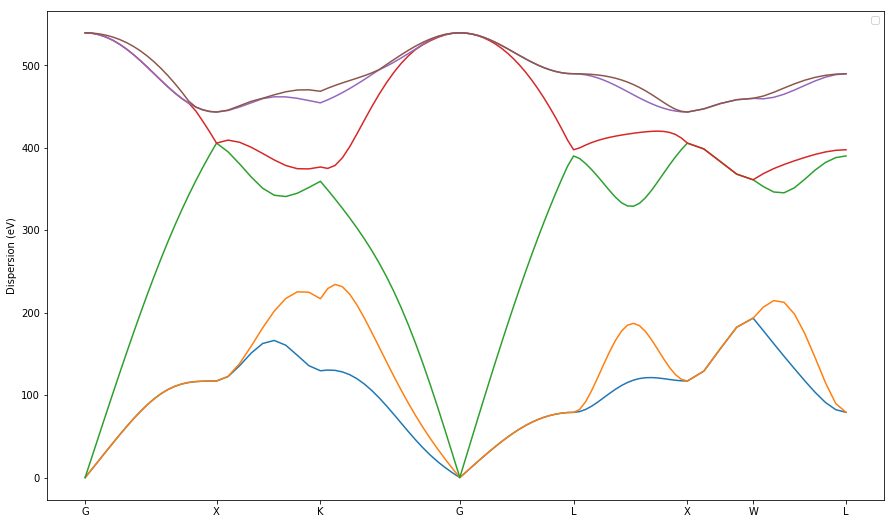

In [76]:
plt.rcParams['figure.figsize'] = (15.0, 9.0)

# Plot bands
for band in zip(*bands.get_bands()):
    plt.plot(bparams['kp_coordinates'], band,)

ticks = [(bparams['kp_coordinates'][xt], xl) 
         for xt, xl in bandskpoints.labels]
plt.xticks(zip(*ticks)[0], zip(*ticks)[1])

#plt.axis([0.0, 3.34, -30.0, 25.0])  # rescale
plt.ylabel("Dispersion (eV)")
plt.legend()

plt.show()